# Image (Face) Generation with Autoencoders

This project demonstrates the use of three different Autoencoder architectures to generate and reconstruct human faces from a dataset sourced from Hugging Face. The models include a basic linear Autoencoder, a Convolutional Autoencoder, and a Variational Autoencoder (VAE). Each model was trained to compress high-dimensional facial image data into lower-dimensional representations and then reconstruct the images from these compressed forms. The goal is to explore the effectiveness of different autoencoder designs in learning compact, meaningful representations of facial features, which can be used for tasks like image denoising, generation, or anomaly detection.


In [1]:
from datasets import load_dataset,DatasetDict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import io
import os
from PIL import Image
import random
import torchvision.transforms as transforms
import utils
import torch.nn as nn
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm
import time

/home/omar/TUM/05_projects/Image_generation_with_VAE/vae_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Download and split the dataset into train,test and validation sets. 

In [2]:
ds = load_dataset("Karthik11232/human_face_generation")
#split the dataset 
train_test_set = ds['train'].train_test_split(test_size=0.1)
#print(train_test_set)
train_val_set = train_test_set['train'].train_test_split(test_size=0.1)

ds = DatasetDict({
    'train': train_test_set['train'],
    'test': train_test_set['test'],
    'validation': train_val_set['test']
})
#print (ds)
print(ds.shape)#complete dataset
print(train_test_set.shape)#train_val and test set
print(train_val_set.shape)#train val and test set

{'train': (2398, 1), 'test': (267, 1), 'validation': (240, 1)}
{'train': (2398, 1), 'test': (267, 1)}
{'train': (2158, 1), 'test': (240, 1)}


Save the datasets to disk

In [3]:
# Save the datasets to disk
output_dir = './human_face_generation_split/raw'
if not os.path.exists(output_dir):  #check if the directory already exists
    os.makedirs(output_dir, exist_ok=True)
# Save each split to disk
    utils.save_images(ds['train'], 'train',output_dir)
    utils.save_images(ds['validation'], 'validation',output_dir)
    utils.save_images(ds['test'], 'test',output_dir)

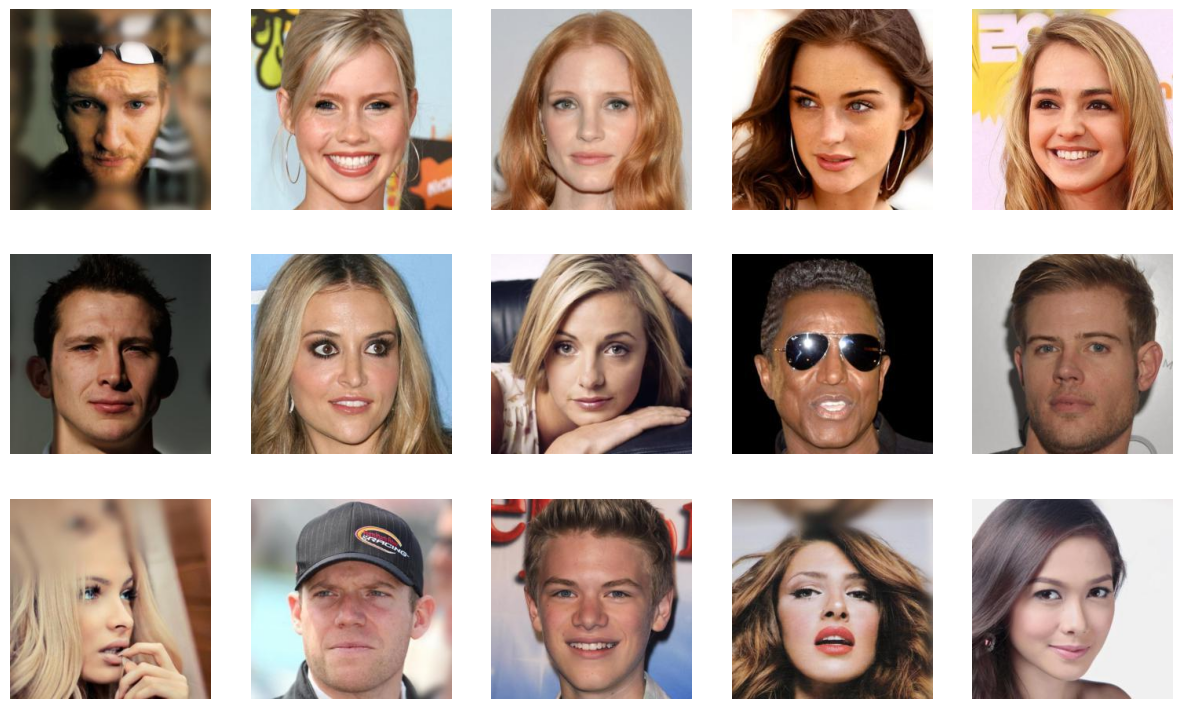

In [4]:
# Plot 15 random images in 3 rows and 5 columns
utils.plot_random_images(dataset_path='human_face_generation_split/raw/train', num_images=15, rows=3, cols=5)

In [5]:
# Prepoccessing 
preprocess = transforms.Compose([
    transforms.Resize((50, 50)),  # Resize to a specific size if needed tried 200x200 was too big
    transforms.ToTensor(),          # Convert to tensor and normalize
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
preprocessed_output_dir = './human_face_generation_split/preprocessed'
os.makedirs(preprocessed_output_dir, exist_ok=True)
if not os.path.exists(preprocessed_output_dir):#
# Save preprocessed training images

    utils.save_images(ds['train'], 'train', preprocessed_output_dir,preprocess=preprocess)
    utils.plot_random_images(os.path.join(preprocessed_output_dir, 'train'), num_images=15, rows=3, cols=5)
    img = Image.open("human_face_generation_split/preprocessed/train/image_2110.png")
    print(img.size)


In [29]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder, img_size=50, flatten=False):
        """
        Args:
            image_folder (str): Path to the folder containing images.
            img_size (int): Size to which each image is resized.
            flatten (bool): Whether to flatten the image into a 1D array.
        """
        self.image_folder = image_folder
        self.img_size = img_size
        self.flatten = flatten
        self.images = os.listdir(image_folder)
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),  # Resize images to img_size x img_size
            transforms.ToTensor()                    # Convert images to PyTorch tensors
        ])

    def __getitem__(self, idx):
        image_file = self.images[idx]
        image = Image.open(os.path.join(self.image_folder, image_file))
        image = self.transform(image)

        if self.flatten:
            image = np.array(image).reshape(-1,50*50) # Flatten the image into a 1D array

        return image

    def __len__(self):
        return len(self.images)
    
dataset_preprocessed = ImageDataset("human_face_generation_split/preprocessed/train")
dataset_preprocessed_lin = ImageDataset("human_face_generation_split/preprocessed/train",flatten=True)

dataset_val = ImageDataset("human_face_generation_split/raw/validation")
dataset_val_lin  = ImageDataset("human_face_generation_split/raw/validation",flatten=True)
dataset_test = ImageDataset("human_face_generation_split/raw/test")
show_dataset = ImageDataset("human_face_generation_split/show_imgs/train")
show_dataset_lin = ImageDataset("human_face_generation_split/show_imgs/train",flatten=True)

train_data = torch.utils.data.DataLoader(dataset_preprocessed,batch_size=32,shuffle=True)
train_data_lin = torch.utils.data.DataLoader(dataset_preprocessed_lin,batch_size=32,shuffle=True)
val_data_lin = torch.utils.data.DataLoader(dataset_val_lin)
val_data = torch.utils.data.DataLoader(dataset_val)
test_data = torch.utils.data.DataLoader(dataset_test)
show_data =torch.utils.data.DataLoader(show_dataset)
show_data_lin =torch.utils.data.DataLoader(show_dataset_lin)

# Linear Autoencoder

This autoencoder consists of linear layers with ReLU activation functions, designed to compress and reconstruct 50x50 pixel images. The model architecture includes three fully connected layers in both the encoder and decoder, with hidden layers of size 512. Xavier initialization is applied to the weights to ensure a good starting point for training. This initialization helps improve convergence and performance by maintaining the variance of the weights across layers.


In [30]:
class Autoencoder_linear(nn.Module):
    def __init__(self):
        super().__init__()
        self.size_hidden_layers = 512 
        self.encoder = nn.Sequential(
            nn.Linear(2500 ,2048),
            nn.ReLU(),
            nn.Linear(2048,1024),
            nn.ReLU(),
            nn.Linear(1024,self.size_hidden_layers),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.size_hidden_layers,1024),
            nn.ReLU(),
            nn.Linear(1024,2048),
            nn.ReLU(),
            nn.Linear(2048,2500),
            nn.ReLU(),
        )        # Apply weight initialization
        self.apply(self.init_weights)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

   # init_weights(self.encoder)
    def forward(self,x):
        encoded=self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded,decoded

In [31]:
# Example usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# For Linear Autoencoder
linear_auto = Autoencoder_linear()
utils.train_autoencoder(linear_auto, train_data_lin, val_data_lin, device, epochs=101, lr=1e-4, ckpt_dir="human_face_generation_split", arch_name="lin", loss_fn="mse")


Epoch 1/101: 100%|██████████| 67/67 [00:01<00:00, 34.55batch/s, train_loss=0.171]


Epoch 1/101 : train_loss = 0.1074, val_loss = 0.0741


Epoch 2/101: 100%|██████████| 67/67 [00:01<00:00, 35.38batch/s, train_loss=0.114] 


Epoch 2/101 : train_loss = 0.0718, val_loss = 0.0466


Epoch 3/101: 100%|██████████| 67/67 [00:01<00:00, 35.39batch/s, train_loss=0.0877]


KeyboardInterrupt: 

In [33]:
linear_auto = Autoencoder_linear()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(linear_auto.parameters(), lr=1e-4)
checkpoint = torch.load("human_face_generation_split/20240903_181548_lin/checkpoint_epoch_1.pt", weights_only=True)
linear_auto.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['train_loss']
#linear_auto.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Assuming you want to plot 5 images
utils.plot_original_and_reconstructed(linear_auto, show_dataset_lin, num_images=5,device=device)


cuda:0


AttributeError: 'numpy.ndarray' object has no attribute 'to'

In [34]:
class Autoencoder_conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels = 3 , out_channels = 32, kernel_size = 2 ,stride = 2),
            nn.ReLU(),# possibly add max pooling
            nn.Conv2d(in_channels = 32,out_channels = 64, kernel_size = 2, stride = 2),
            nn.ReLU()
        )    
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 64,out_channels=32,kernel_size=3,stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 32 , out_channels = 3 ,kernel_size=2,stride =2),
            nn.ReLU()
        )
    def forward(self,x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return encoded, decoded

In [35]:

conv_auto = Autoencoder_conv()  # Assuming you have this class defined
utils.train_autoencoder(conv_auto, train_data, val_data, device, epochs=101, lr=1e-4, ckpt_dir="human_face_generation_split", arch_name="conv", loss_fn="mse")


Epoch 1/101: 100%|██████████| 67/67 [00:01<00:00, 56.20batch/s, train_loss=0.422]


Epoch 1/101 : train_loss = 0.2651, val_loss = 0.2299


Epoch 2/101: 100%|██████████| 67/67 [00:00<00:00, 75.35batch/s, train_loss=0.364]


Epoch 2/101 : train_loss = 0.2287, val_loss = 0.1832


Epoch 3/101: 100%|██████████| 67/67 [00:00<00:00, 76.70batch/s, train_loss=0.293]


Epoch 3/101 : train_loss = 0.1843, val_loss = 0.1563


Epoch 4/101: 100%|██████████| 67/67 [00:00<00:00, 78.82batch/s, train_loss=0.244]


Epoch 4/101 : train_loss = 0.1531, val_loss = 0.1194


Epoch 5/101: 100%|██████████| 67/67 [00:00<00:00, 73.35batch/s, train_loss=0.197]


Epoch 5/101 : train_loss = 0.1237, val_loss = 0.0935


Epoch 6/101: 100%|██████████| 67/67 [00:00<00:00, 75.86batch/s, train_loss=0.157] 


Epoch 6/101 : train_loss = 0.0985, val_loss = 0.0723


Epoch 7/101: 100%|██████████| 67/67 [00:00<00:00, 79.99batch/s, train_loss=0.134] 


Epoch 7/101 : train_loss = 0.0840, val_loss = 0.0620


Epoch 8/101: 100%|██████████| 67/67 [00:00<00:00, 76.07batch/s, train_loss=0.107] 


KeyboardInterrupt: 

cuda:0
Original shape: (1, 3, 50, 50), Reconstructed shape: (1, 3, 50, 50)
Original shape: (1, 3, 50, 50), Reconstructed shape: (1, 3, 50, 50)
Original shape: (1, 3, 50, 50), Reconstructed shape: (1, 3, 50, 50)
Original shape: (1, 3, 50, 50), Reconstructed shape: (1, 3, 50, 50)
Original shape: (1, 3, 50, 50), Reconstructed shape: (1, 3, 50, 50)


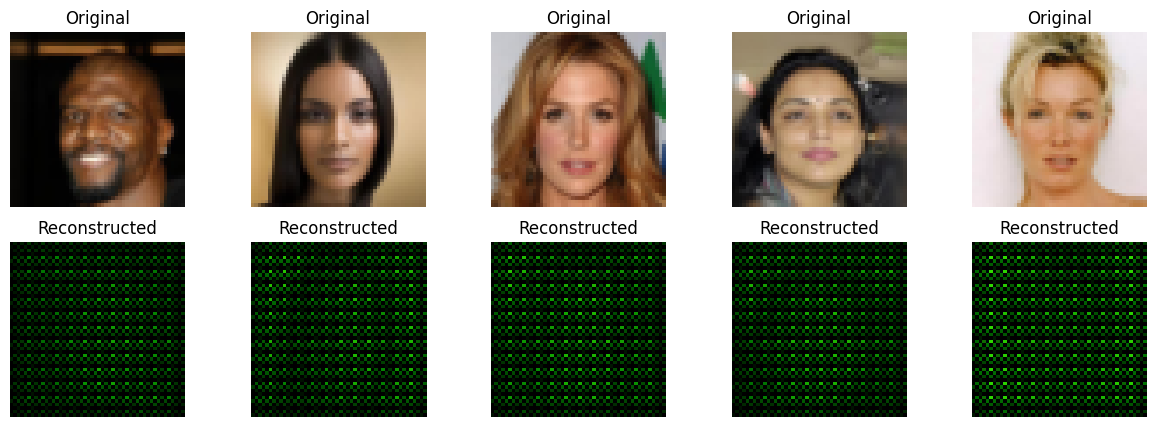

In [37]:
auto_conv = Autoencoder_conv()
optimizer = torch.optim.Adam(auto_conv.parameters(), lr=1e-4)
checkpoint = torch.load("human_face_generation_split/20240903_181728_conv/checkpoint_epoch_1.pt", weights_only=True)
auto_conv.load_state_dict(checkpoint['state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch torchvision.ckpoint['epoch']
#loss = checkpoint['train_loss']
#linear_auto.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


# Assuming you want to plot 5 images
utils.plot_original_and_reconstructed(auto_conv, show_data,device, num_images=5)


In [90]:
import gc

vae.cpu()
del vae
gc.collect()
torch.cuda.empty_cache()

In [39]:
# VAE
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels = 3 , out_channels = 256, kernel_size = 2 ,stride = 2),
           # nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,inplace=True),# possibly add max pooling
            #nn.Dropout(0.25),
            nn.Conv2d(in_channels = 256,out_channels = 512, kernel_size = 2, stride = 2),
            #nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2,inplace=True),# possibly add max pooling
           # nn.Dropout(0.25),
        )    
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 512,out_channels=256,kernel_size=3,stride=2),
          #  nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,inplace=True),# possibly add max pooling
           # nn.Dropout(0.25),
            nn.ConvTranspose2d(in_channels = 256 , out_channels = 3 ,kernel_size=2,stride =2),
            nn.LeakyReLU(0.2,inplace=True)# possibly add max pooling
        )
        
        # latent mean and variance 
   # Latent space
        self.fc1 = nn.Linear(512*12*12, 256)  # Map to latent mean
        self.fc2 = nn.Linear(512*12*12, 256)  # Map to latent logvar
        self.fc3 = nn.Linear(256, 512*12*12)  # Map back from latent space to decoder input
        self.apply(self.init_weights)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten for the linear layers
        mean = self.fc1(x)
        logvar = self.fc2(x)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        #std = torch.exp(0.5 * logvar)

        epsilon = torch.randn_like(logvar).to(device)      
        z = mean + logvar*epsilon
        return z


    def decode(self, z):
        z = self.fc3(z)
        z = z.view(z.size(0), 512, 12, 12)  # Reshape to the dimensions expected by the decoder
        x_hat = self.decoder(z)
        return x_hat


    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar
  

In [40]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
   # print(f'Reconstruction Loss: {reproduction_loss.item()}, KL Divergence: {KLD.item()}')

    return reproduction_loss + KLD


In [41]:
# For Variational Autoencoder (VAE)
vae = VAE()  # Assuming you have this class defined
utils.train_autoencoder(vae, train_data, val_data, device, epochs=101, lr=1e-4, ckpt_dir="human_face_generation_split", arch_name="vae", loss_fn="vae")

Epoch 1/101: 100%|██████████| 67/67 [00:05<00:00, 11.35batch/s, train_loss=3.22e+4]


Epoch 1/101 : train_loss = 20254.4702, val_loss = 267.0099


Epoch 2/101:  40%|████      | 27/67 [00:02<00:03, 10.90batch/s, train_loss=1.17e+4]


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.028239299..0.77041125].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.015757311..1.0576501].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.002339846..0.9139722].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.006786898..0.86682653].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0017572939..1.0853904].


cuda:0
Original shape: (1, 3, 50, 50), Reconstructed shape: (1, 3, 50, 50)
Original shape: (1, 3, 50, 50), Reconstructed shape: (1, 3, 50, 50)
Original shape: (1, 3, 50, 50), Reconstructed shape: (1, 3, 50, 50)
Original shape: (1, 3, 50, 50), Reconstructed shape: (1, 3, 50, 50)
Original shape: (1, 3, 50, 50), Reconstructed shape: (1, 3, 50, 50)


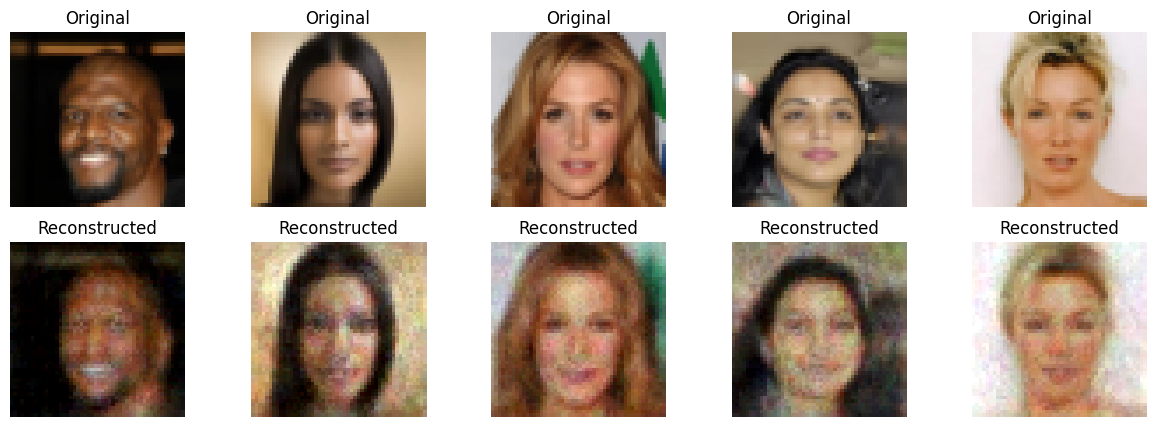

In [79]:
vae = VAE()
#optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)
checkpoint = torch.load("human_face_generation_split/20240903_165150vae/checkpoint_epoch_81.pt", weights_only=True)
vae.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch torchvision.ckpoint['epoch']
#loss = checkpoint['train_loss']
#linear_auto.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

def plot_original_and_reconstructed(model, dataloader, device,num_images=5):
    model.to(device)
    model.eval()  # Set the model to evaluation mode
    
    images = []
    reconstructed_images = []
    
    with torch.no_grad():
        for _, data in enumerate(dataloader):
            data = data.to(device)  # Move data to the same device as the model
            reconstructed,_, _ = model(data)
            
            # Move tensors back to CPU for visualization
            data = data.cpu().numpy()
            reconstructed = reconstructed.cpu().numpy()
            print(f"Original shape: {data.shape}, Reconstructed shape: {reconstructed.shape}")  # Debugging output

            images.extend(data[:num_images])  # Original images
            reconstructed_images.extend(reconstructed[:num_images])  # Reconstructed images
            
            if len(images) >= num_images:
                break

    # Plot the original and reconstructed images side by side
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        # Original images
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].reshape(3, 50, 50).transpose(1, 2, 0))  # Reshape and transpose for RGB
        plt.title("Original")
        plt.axis('off')
        
        # Reconstructed images
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstructed_images[i].reshape(3, 50, 50).transpose(1, 2, 0))  # Reshape and transpose for RGB
        plt.title("Reconstructed")
        plt.axis('off')
    
    plt.show()
# Assuming you want to plot 5 images
plot_original_and_reconstructed(vae, show_data,device, num_images=5)
